In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
from datetime import datetime
import deepinv as dinv
import gc
from pathlib import Path
from time import time
import math

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.fft import dct, idct
import seaborn as sns
from tqdm import tqdm, trange
import yaml
from dotmap import DotMap

from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing, spectral_methods_wrapper, plot_error_bars, generate_signal, load_config
from deepinv.models.complex import to_complex_denoiser

In [3]:
config = load_config('paper/config/structured_spectral.yaml')

In [4]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 32491 MB free memory 


device(type='cuda', index=0)

In [5]:
print(config)

DotMap(general=DotMap(name='structured_FDF', recon='spec', save=True), signal=DotMap(img_size=64, mode='shepp-logan', config=DotMap(varying_norm=True, noise_ratio=0.0, max_scale=3.0)), model=DotMap(n_layers=1, diagonal=DotMap(mode='uniform_phase', config=DotMap(degree_of_freedom=30, complex=True)), transform='fft', shared_weights=False, drop_tail=False), recon=DotMap(series='arange', start=2, end=194, list=[], n_repeats=50, max_iter=5000), save=DotMap(path='../runs', name='res_{model_name}_{img_mode}_{recon}_{oversampling_start}-{oversampling_end}_{n_repeats}repeat.csv'))


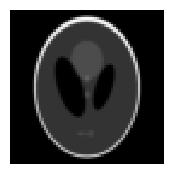

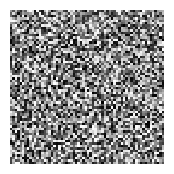

tensor(19.9972, device='cuda:0') tensor(0.0022, device='cuda:0')


torch.complex64

In [12]:
config.signal.mode = 'shepp-logan'
config.signal.config.noise_ratio = 0.4
config.signal.config.varying_norm = True
config.signal.config.max_scale = 20.0

x = generate_signal(config.signal.img_size, config.signal.mode, config.signal.config, dtype=torch.complex64, device=device)
plot(x.angle())
plot(x.abs())
print(x.abs().max(), x.abs().min())
x.dtype

norm of x:  tensor(64., device='cuda:0')
norm of Fx:  tensor(64., device='cuda:0')
norm of FDx:  tensor(64.0000, device='cuda:0')
norm of FDFDx:  tensor(64.0000, device='cuda:0')
norm of FDFDFDx:  tensor(64.0000, device='cuda:0')
norm of FDFDFDFDx:  tensor(64.0000, device='cuda:0')
norm of FDFDFDFDFDx:  tensor(64.0000, device='cuda:0')
norm of FDFDFDFDFDFDx:  tensor(64.0000, device='cuda:0')


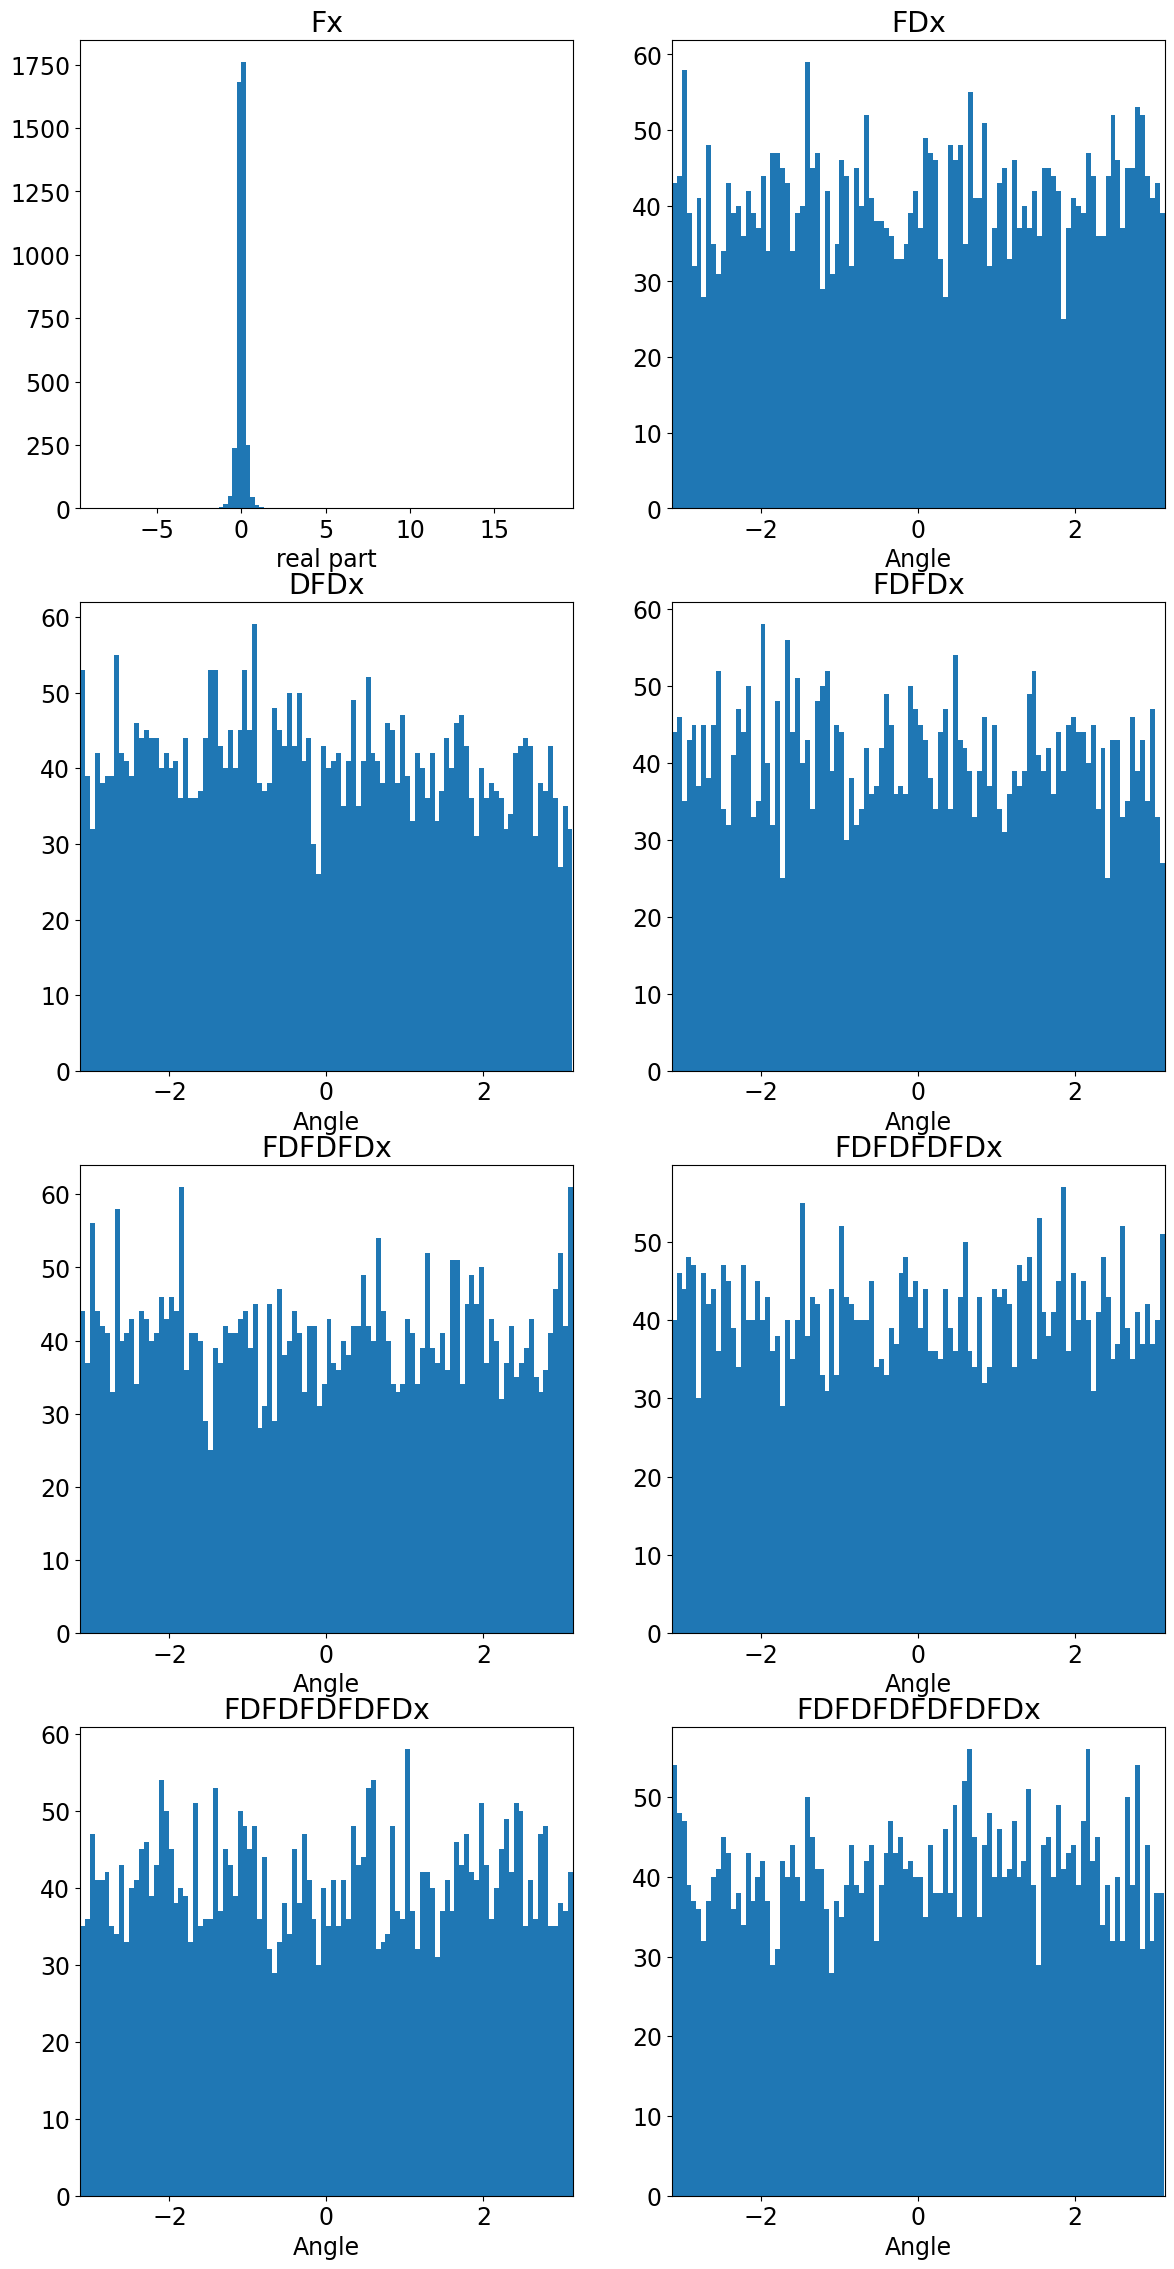

In [11]:
D = torch.rand_like(x,dtype=torch.float)
D = torch.exp(1j*2*torch.pi*D - 1j*torch.pi).to(device)
Fx = torch.fft.fft2(x, norm='ortho')
Dx = D*x
FDx = torch.fft.fft2(Dx, norm='ortho')
DFDx = D*FDx
FDFDx = torch.fft.fft2(DFDx, norm='ortho')
FDFDFDx = torch.fft.fft2(D*FDFDx, norm='ortho')
FDFDFDFDx = torch.fft.fft2(D*FDFDFDx, norm='ortho')
FDFDFDFDFDx = torch.fft.fft2(D*FDFDFDFDx, norm='ortho')
FDFDFDFDFDFDx = torch.fft.fft2(D*FDFDFDFDFDx, norm='ortho')
print("norm of x: ", torch.linalg.norm(x))
print("norm of Fx: ", torch.linalg.norm(Fx))
print("norm of FDx: ", torch.linalg.norm(FDx))
print("norm of FDFDx: ", torch.linalg.norm(FDFDx))
print("norm of FDFDFDx: ", torch.linalg.norm(FDFDFDx))
print("norm of FDFDFDFDx: ", torch.linalg.norm(FDFDFDFDx))
print("norm of FDFDFDFDFDx: ", torch.linalg.norm(FDFDFDFDFDx))
print("norm of FDFDFDFDFDFDx: ", torch.linalg.norm(FDFDFDFDFDFDx))

figure, ax = plt.subplots(4,2,figsize=(14,28))
ax[0,0].hist(Fx.real.flatten().cpu(), bins=100)
ax[0,0].set_xlabel('real part')
#ax[0,0].set_xlim(-5,5)
ax[0,0].set_title('Fx')
ax[0,1].hist(FDx.angle().flatten().cpu(), bins=100)
ax[0,1].set_xlabel('Angle')
ax[0,1].set_xlim(-torch.pi,torch.pi)
ax[0,1].set_title('FDx')
ax[1,0].hist(DFDx.angle().flatten().cpu(), bins=100)
ax[1,0].set_xlabel('Angle')
ax[1,0].set_xlim(-torch.pi,torch.pi)
ax[1,0].set_title('DFDx')
ax[1,1].hist(FDFDx.angle().flatten().cpu(), bins=100)
ax[1,1].set_xlabel('Angle')
ax[1,1].set_xlim(-torch.pi,torch.pi)
ax[1,1].set_title('FDFDx')
ax[2,0].hist(FDFDFDx.angle().flatten().cpu(), bins=100)
ax[2,0].set_xlabel('Angle')
ax[2,0].set_xlim(-torch.pi,torch.pi)
ax[2,0].set_title('FDFDFDx')
ax[2,1].hist(FDFDFDFDx.angle().flatten().cpu(), bins=100)
ax[2,1].set_xlabel('Angle')
ax[2,1].set_xlim(-torch.pi,torch.pi)
ax[2,1].set_title('FDFDFDFDx')
ax[3,0].hist(FDFDFDFDFDx.angle().flatten().cpu(), bins=100)
ax[3,0].set_xlabel('Angle')
ax[3,0].set_xlim(-torch.pi,torch.pi)
ax[3,0].set_title('FDFDFDFDFDx')
ax[3,1].hist(FDFDFDFDFDFDx.angle().flatten().cpu(), bins=100)
ax[3,1].set_xlabel('Angle')
ax[3,1].set_xlim(-torch.pi,torch.pi)
ax[3,1].set_title('FDFDFDFDFDFDx')
plt.show()

# Variance propagation through the structured random model

var of x_phase:  tensor(0.2414, device='cuda:0')
var of Dx:  tensor(0.2416, device='cuda:0')
var of Fx:  tensor(0.2416, device='cuda:0')
var of FFx:  tensor(0.2414, device='cuda:0')
var of DFx:  tensor(0.2416, device='cuda:0')
var of FDx:  tensor(0.2416, device='cuda:0')
var of FDFx:  tensor(0.2414, device='cuda:0')
var of DFDx:  tensor(0.2415, device='cuda:0')
var of FDFDx:  tensor(0.2416, device='cuda:0')
var of DFDFDx:  tensor(0.2415, device='cuda:0')
var of FDFDFDx:  tensor(0.2415, device='cuda:0')
var of DFDFDFDx:  tensor(0.2416, device='cuda:0')


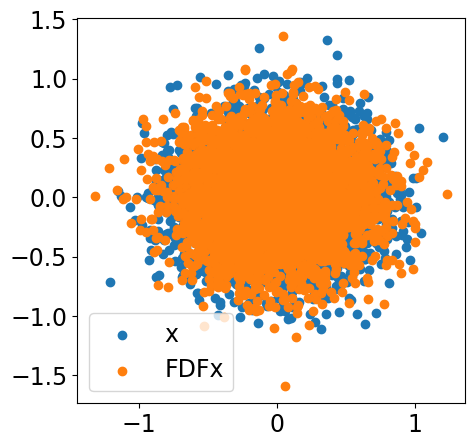

In [36]:
x_phase = 0.5*torch.randn((64,64),dtype=torch.complex64,device=device)
print('var of x_phase: ', x_phase.var())
# random diagonal matrix
# A = torch.randn((64,64),dtype=torch.complex64,device=device)
A = torch.rand((64,64), device=device)
A = 2 * np.pi * A
A = torch.exp(1j * A)
Dx = A * x_phase
print('var of Dx: ', Dx.var())
Fx = torch.fft.fft2(x_phase, norm='ortho')
print('var of Fx: ', Fx.var())
FFx = torch.fft.fft2(Fx, norm='ortho')
print('var of FFx: ', FFx.var())
DFx = A * Fx
print('var of DFx: ', DFx.var())
# fft
FDx = torch.fft.fft2(Dx, norm='ortho')
print('var of FDx: ', FDx.var())
FDFx = torch.fft.fft2(DFx, norm='ortho')
print('var of FDFx: ', FDFx.var())
# random diagonal matrix
DFDx = A * FDx
print('var of DFDx: ', DFDx.var())
# fft
FDFDx = torch.fft.fft2(DFDx, norm='ortho')
print('var of FDFDx: ', FDFDx.var())
# random diagonal matrix
DFDFDx = A * FDFDx
print('var of DFDFDx: ', DFDFDx.var())
# fft
FDFDFDx = torch.fft.fft2(DFDFDx, norm='ortho')
print('var of FDFDFDx: ', FDFDFDx.var())
# random diagonal matrix
DFDFDFDx = A * FDFDFDx
print('var of DFDFDFDx: ', DFDFDFDx.var())
# plot x_phase and FDFx
plt.figure(figsize=(5,5))
plt.scatter(x_phase.cpu().numpy().real,x_phase.cpu().numpy().imag,label='x')
plt.scatter(FDFx.cpu().numpy().real,FDFx.cpu().numpy().imag,label='FDFx')
plt.legend()
plt.show()

In [26]:
x = torch.randn(4,dtype=torch.complex64)
x_fft = torch.fft.fft(x,norm='ortho')
x_2fft = torch.fft.fft(x_fft,norm='ortho')
x_3fft = torch.fft.fft(x_2fft,norm='ortho')
x_4fft = torch.fft.fft(x_3fft,norm='ortho')
print(x)
print(x_fft)
print(x_2fft)
print(x_3fft)
print(x_4fft)

tensor([-0.9032-0.5999j, -0.7981+0.5828j, -0.5665+0.6771j,  0.3105+0.0076j])
tensor([-0.9787+0.3338j,  0.1193-0.0842j, -0.4910-0.2566j, -0.4559-1.1928j])
tensor([-0.9032-0.5999j,  0.3105+0.0076j, -0.5665+0.6771j, -0.7981+0.5828j])
tensor([-0.9787+0.3338j, -0.4559-1.1928j, -0.4910-0.2566j,  0.1193-0.0842j])
tensor([-0.9032-0.5999j, -0.7981+0.5828j, -0.5665+0.6771j,  0.3105+0.0076j])


In [58]:
# randomly sample n 6-dimensional vectors and compute the mean and variance of each compoenent of its fft
n = 1,000,000
# mean mu, var 1
mu = 3
p = 6
x = torch.randn((n,p)) + mu
# fft dc component should have mean mu*sqrt(p), other components should have mean 0
x_fft = torch.fft.fft(x,norm='ortho',dim=1)
print(math.sqrt(p)*mu)
print(x_fft.var(dim=0))
print(x_fft.mean(dim=0))

7.348469228349534
tensor([1.0002, 0.9983, 1.0016, 0.9984, 1.0016, 0.9983])
tensor([ 7.3467e+00+0.0000j, -3.0501e-04-0.0004j, -1.2356e-03-0.0002j,
         7.3551e-04+0.0000j, -1.2356e-03+0.0002j, -3.0501e-04+0.0004j])


In [37]:
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

In [40]:
x_dct = dct2(x_phase.cpu().numpy())
x_dct_inv = idct2(x_dct)

(x_dct - x_phase.cpu().numpy()).real.max()

4.125279

In [48]:
import numpy as np
from scipy.fft import dct, idct

def dct2_unitary(x):
    """ Compute the 2D unitary DCT. """
    # Apply DCT along columns (axis=0) with norm='ortho' to normalize
    return dct(dct(x, axis=-1, norm='ortho'), axis=-2, norm='ortho')

def idct2_unitary(x):
    """ Compute the 2D unitary inverse DCT. """
    # Apply inverse DCT along columns (axis=0) with norm='ortho' to normalize
    return idct(idct(x, axis=-1, norm='ortho'), axis=-2, norm='ortho')

# Example usage:
x = torch.rand((4, 4), dtype=torch.complex64).numpy()  # Example 4x4 matrix
dct_x = dct2_unitary(x)    # Apply unitary 2D DCT
idct_x = idct2_unitary(dct_x)  # Apply unitary 2D inverse DCT

print("Original matrix:\n", x)
print("DCT of the matrix:\n", dct_x)
print("Reconstructed matrix (should be close to original):\n", idct_x)

Original matrix:
 [[0.33365548+0.57661504j 0.93412757+0.1676752j  0.23890334+0.86818725j
  0.70052975+0.01846337j]
 [0.9678967 +0.71349746j 0.19003206+0.6896446j  0.26734912+0.58087724j
  0.5272573 +0.9248848j ]
 [0.12311012+0.07806391j 0.41102535+0.6057623j  0.89508104+0.03864437j
  0.49382973+0.3820166j ]
 [0.7072417 +0.8548129j  0.45439738+0.806428j   0.9614929 +0.9306388j
  0.7580696 +0.7139804j ]]
DCT of the matrix:
 [[ 2.2409997 +2.2375479j  -0.16409944+0.0398481j   0.06479545-0.10638084j
   0.07486211+0.07346325j]
 [-0.21616118-0.30296093j  0.25087297+0.05902688j  0.17215762-0.01430277j
  -0.5814832 +0.4075278j ]
 [ 0.30320895+0.23085247j -0.05787037+0.19361693j -0.10950775-0.19814791j
  -0.31079245+0.65445656j]
 [-0.1008219 -0.8160109j  -0.38600278+0.07309459j -0.5895611 -0.217237j
  -0.20552689-0.07954262j]]
Reconstructed matrix (should be close to original):
 [[0.33365548+0.576615j   0.9341274 +0.16767521j 0.23890337+0.8681871j
  0.7005297 +0.01846335j]
 [0.9678967 +0.7134973

# Time complexity

In [5]:
# img_sizes: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 256]
img_sizes: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
print(img_sizes)
n_repeats = 100
oversampling = 1

[8, 16, 32, 64, 96, 128, 160, 192, 224, 240]


In [6]:
device = torch.device("cuda",index=0)
device

device(type='cuda', index=0)

In [7]:
torch.cuda.empty_cache()

In [6]:
# works well if not in class
foo = torch.randn((240**2, 240**2), device=device, dtype=torch.complex64)
bar = foo

In [ ]:
# problem is the division
class Foo:
    def __init__(self):
        self.foo = torch.randn((240**2, 240**2), device=device, dtype=torch.complex64) / np.sqrt(240**2)

Foo().foo

In [6]:
physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*240**2),
            img_shape= (1, 240, 240),
            dtype = torch.complex64,
            device=device,
            test=True,
        )

In [7]:
physics.release_memory()

allocated memory: 0


In [ ]:
# random model

df_random_gpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    torch.cuda.empty_cache()
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device)
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)
    torch.cuda.synchronize()
    for i in range(n_repeats):
        physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*torch.prod(torch.tensor(x.shape))),
            img_shape= (1, img_size, img_size),
            dtype = torch.complex64,
            device=device,
            test=True,
        )
        torch.cuda.synchronize()
        init_time = time()
        y = physics.forward(x_phase)
        torch.cuda.synchronize()
        df_random_gpu.loc[i, f"img_size_{img_size}"] = time() - init_time
        physics.release_memory()
        torch.cuda.empty_cache()
        print("allocated memory after clearing cache", torch.cuda.memory_allocated(device)/1024**2,"MB")

In [7]:
df_random_gpu.to_csv("df_random_gpu.csv", index=False)
df_random_gpu

,img_size_8,img_size_16,img_size_32,img_size_64,img_size_96,img_size_128,img_size_160,img_size_192,img_size_224,img_size_240
0,0.451463,0.000501,0.000638,0.00054,0.001046,0.003431,0.007872,0.016202,0.029026,0.031205
1,0.000252,0.000467,0.000466,0.000386,0.0012,0.00333,0.007773,0.016022,0.023464,0.031089
2,0.000179,0.00046,0.000462,0.000367,0.001196,0.003243,0.007803,0.016826,0.02349,0.031042
3,0.00017,0.000459,0.000453,0.000364,0.001208,0.003246,0.00778,0.016126,0.023477,0.03113
4,0.000168,0.000459,0.000451,0.000364,0.001168,0.003349,0.007809,0.015985,0.023582,0.031191
...,...,...,...,...,...,...,...,...,...,...
95,0.000164,0.000173,0.000174,0.000299,0.001241,0.003373,0.007748,0.016134,0.023584,0.031102
96,0.000164,0.000172,0.00017,0.000296,0.001233,0.0034,0.007826,0.016018,0.023588,0.030983
97,0.000164,0.000172,0.000168,0.000296,0.00123,0.003401,0.00777,0.016045,0.023482,0.031095
98,0.000165,0.000174,0.000168,0.000297,0.001246,0.003392,0.007826,0.015952,0.023474,0.031016


In [10]:
# structured model
df_structured_gpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    img_size = img_size
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device)
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

    torch.cuda.synchronize()
    for i in range(n_repeats):
        physics = dinv.physics.StructuredRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
            dtype = torch.complex64,
            device=device,
        )
        init_time = time()
        torch.cuda.synchronize()
        y = physics.forward(x_phase)
        df_structured_gpu.loc[i, f"img_size_{img_size}"] = time() - init_time
        torch.cuda.synchronize()
        physics.release_memory()
        torch.cuda.synchronize()

100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


In [12]:
df_structured_gpu.to_csv("paper/data/time/df_structured_gpu.csv", index=False)
df_structured_gpu

,img_size_8,img_size_16,img_size_32,img_size_64,img_size_96,img_size_128,img_size_160,img_size_192,img_size_224,img_size_240
0,0.000622,0.0006,0.000474,0.000599,0.000604,0.000614,0.000616,0.000591,0.000397,0.000668
1,0.000585,0.000626,0.000453,0.000578,0.000588,0.000577,0.000574,0.000545,0.000395,0.000636
2,0.000584,0.000567,0.000442,0.000568,0.000572,0.00057,0.000571,0.000577,0.000364,0.000632
3,0.000579,0.000568,0.000445,0.000576,0.000567,0.000571,0.000571,0.000528,0.000362,0.000626
4,0.000577,0.000563,0.000445,0.000562,0.000567,0.000567,0.000566,0.000531,0.00036,0.000572
...,...,...,...,...,...,...,...,...,...,...
95,0.0002,0.000224,0.000229,0.00023,0.000227,0.000202,0.000216,0.000222,0.000228,0.000211
96,0.000199,0.000221,0.000228,0.000222,0.000212,0.000201,0.000217,0.000209,0.000223,0.000211
97,0.000201,0.000222,0.00025,0.000223,0.000212,0.000196,0.000218,0.000206,0.000223,0.000221
98,0.0002,0.000221,0.000222,0.000222,0.000213,0.000197,0.000217,0.000216,0.000222,0.000205


In [13]:
device = 'cpu'

In [26]:
# random model
df_random_cpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device='cpu')
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to('cpu')

    for i in range(n_repeats):
        physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*torch.prod(torch.tensor(x.shape))),
            img_shape= (1, img_size, img_size),
            dtype = torch.complex64,
            device='cpu',
        )
        init_time = time()
        y = physics.forward(x_phase)
        df_random_cpu.loc[i, f"img_size_{img_size}"] = time() - init_time

 80%|████████  | 8/10 [1:07:40<35:48, 1074.12s/it]

In [16]:
# structured model
df_structured_cpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    img_size = img_size
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device='cpu')
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to('cpu')

    for i in range(n_repeats):
        physics = dinv.physics.StructuredRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
            dtype = torch.complex64,
            device='cpu',
        )
        init_time = time()
        y = physics.forward(x_phase)
        df_structured_cpu.loc[i, f"img_size_{img_size}"] = time() - init_time

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


In [17]:
df_structured_cpu.to_csv("paper/data/time/df_structured_cpu.csv", index=False)
df_structured_cpu.mean(axis=0)

img_size_8      0.000192
img_size_16     0.000185
img_size_32     0.000223
img_size_64     0.000314
img_size_96     0.000435
img_size_128    0.000539
img_size_160    0.000769
img_size_192    0.002995
img_size_224    0.003131
img_size_240    0.003242
dtype: object

In [15]:
pixels = [i**2 for i in img_sizes]

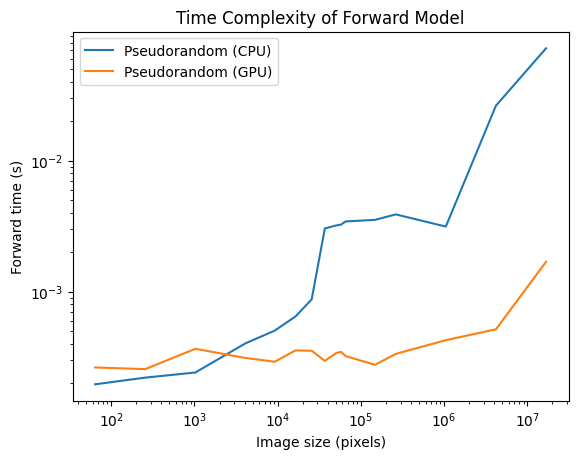

In [22]:
# plt.plot(pixels,df_random_cpu.mean(axis=0),label='Random (CPU)')
# plt.plot(pixels,df_random_gpu.mean(axis=0),label='Random (GPU)')
plt.plot(pixels,df_structured_cpu.mean(axis=0),label='structured (CPU)')
plt.plot(pixels,df_structured_gpu.mean(axis=0),label='structured (GPU)')
plt.xlabel('Image size (pixels)')
plt.ylabel('Forward time (s)')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Time Complexity of Forward Model')
plt.legend()
plt.savefig('time.svg')
plt.show()

In [127]:
# save data
df_random_cpu.to_csv('df_random_cpu.csv')
df_random_gpu.to_csv('df_random_gpu.csv')
df_structured_cpu.to_csv('df_structured_cpu.csv')
df_structured_gpu.to_csv('df_structured_gpu.csv')

In [ ]:
plot_error_bars([pixels] * 4,
                [df_random_cpu, df_random_gpu, df_structured_cpu, df_structured_gpu],
                ['Random (CPU)', 'Random (GPU)', 'structured (CPU)', 'structured (GPU)'],
                title = f'Forward time (s) vs Image size (oversampling={oversampling})',
                xlabel = 'Image size',
                xscale = 'log',
                ylabel = 'Forward time (s)',
                yscale = 'log',
                axis = 0)

# Test playground for i.i.d. random model

In [1]:
# Set up the variable to fetch dataset and operators.
url = get_image_url("shepp-logan")
img_size = 54
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

NameError: name 'get_image_url' is not defined

In [15]:
data_fidelity = L2()
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-3, use 1e-2 for oversampling ratio 3-9
step_size = 1e-2
oversampling = 5

In [101]:
physics = dinv.physics.RandomPhaseRetrieval(
    m=oversampling*torch.prod(torch.tensor(x.shape)),
    img_shape=(1, img_size, img_size),
    dtype=torch.complex64,
    device=device,
)
y = physics(x_phase)
print("estimated norm of x:", torch.sqrt(y.mean()/physics.get_A_var()))
print(torch.sqrt(y.sum()))
print(torch.sqrt((x_phase*x_phase.conj()).sum()))
print("true norm of x:", torch.linalg.vector_norm(x_phase))

estimated norm of x: tensor(53.8626, device='cuda:0')
tensor(6503.2720, device='cuda:0')
tensor(54.-5.1321e-08j, device='cuda:0')
true norm of x: tensor(54., device='cuda:0')


In [52]:
def random_init(y, physics):
    x = torch.randn_like(x_phase)
    z = x.detach().clone()
    return {"est": (x, z)}

In [58]:
params_algo = {"stepsize": step_size * oversampling, "g_params": 0.00}
print("stepsize:", params_algo["stepsize"])
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=random_init,
)

x_phase_gd_spec, metrics = model(y, physics, x_gt=x_phase, compute_metrics=True)

stepsize: 0.05


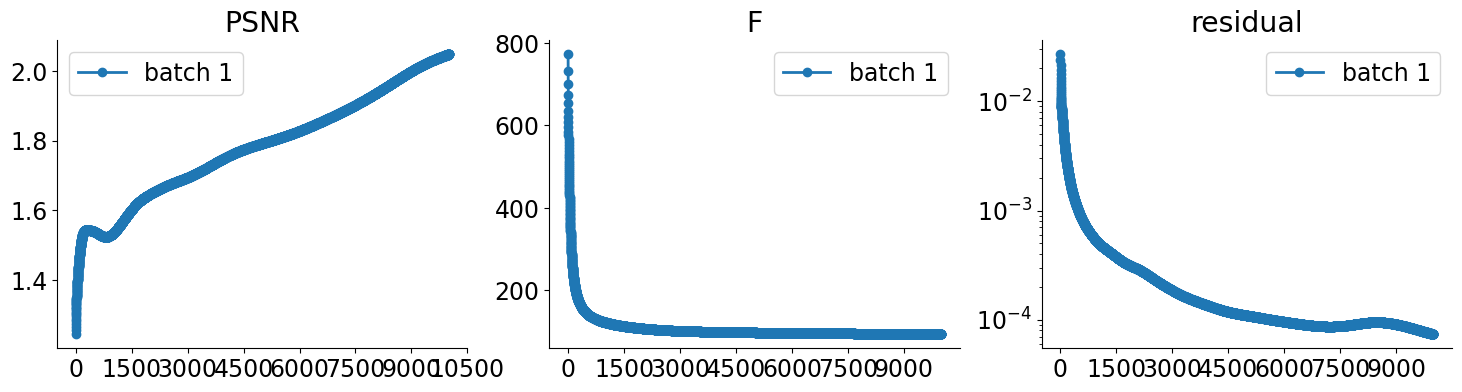

In [59]:
plot_curves(metrics)

Image 0, channel 0 does not have a global phase shift.
Cosine similarity: 0.0650


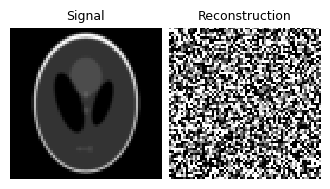

In [60]:
x_phase_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
print(f"Cosine similarity: {cosine_similarity(x_phase_gd_spec, x_phase):.4f}")
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_phase_gd_spec) / torch.pi + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')

In [106]:
oversampling_ratios = torch.cat((torch.arange(0.1,3.1,0.1),torch.arange(3.5,9.5,0.5)))
oversampling_ratios

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000,
        1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000, 2.7000,
        2.8000, 2.9000, 3.0000, 3.5000, 4.0000, 4.5000, 5.0000, 5.5000, 6.0000,
        6.5000, 7.0000, 7.5000, 8.0000, 8.5000, 9.0000])

# Test for diagonals

In [25]:
config = DotMap()
config.range = torch.sqrt(torch.tensor(3.0))

diagonal = dinv.physics.phase_retrieval.generate_diagonal((1, 128, 128), mode='uniform_magnitude', dtype=torch.complex64, config = config)
diagonal.mean()**2 + diagonal.var()

tensor(0.9997+0.j)

# Test playground for structured random model

In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

from dotmap import DotMap
import torch

import deepinv as dinv
from deepinv.optim import optim_builder
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing, spectral_methods_wrapper, plot_error_bars, generate_signal, load_config
from deepinv.utils import plot

In [21]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

input_size = 64
output_size = 128
#x = 1j*2*torch.pi*torch.rand((1,1,input_size,input_size),dtype=torch.complex64,device=device)
x = generate_signal(input_size, 'shepp-logan', DotMap(noise_ratio=0.4, varying_norm=False, max_scale=20.0), dtype=torch.complex64, device=device)

distri_config = DotMap()
distri_config.complex = True

physics = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, input_size, input_size),
    output_shape=(1, output_size, output_size),
    diagonal_mode="uniform_phase",
    transform="fft",
    dtype=torch.complex64,
    device=device,
    distri_config=distri_config,
    #noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img)
)
print("physics structure:", physics.structure)
print("oversampling ratio:", torch.prod(torch.tensor(physics.output_shape)) / torch.prod(torch.tensor(physics.input_shape)))
# y has the shape of (1, output_shape)
y = physics(x)
print("squared mean of one diagonal:", physics.get_A_squared_mean())
#print("estimated norm of x:", torch.sqrt(y.sum()))
print("true norm of x:", torch.linalg.vector_norm(x))
print("norm of FDx: ", torch.linalg.vector_norm(physics.B.A(x)))

Selected GPU 1 with 32091 MB free memory 
physics structure: FDFD
oversampling ratio: tensor(4.)
squared mean of one diagonal: tensor(1.0000-2.3288e-05j, device='cuda:1')
true norm of x: tensor(64., device='cuda:1')
norm of FDx:  tensor(64.0000, device='cuda:1')


In [13]:
torch.sqrt(y.mean()/physics.get_A_squared_mean())

tensor(1.0000+0.j, device='cuda:3')

In [ ]:
print(torch.linalg.vector_norm(x_phase))
#print(torch.linalg.vector_norm(y))
x_spec = spectral_methods(y, physics, n_iter=5000, verbose=True)
print(torch.linalg.vector_norm(x_spec))
print(x_phase.abs())
#print(x_spec.abs())
#print(x_spec)
print(cosine_similarity(x_spec,x_phase))
# check if A and A_adjoint operator of physics are unitary

In [5]:
# check if A and A_adjoint operator of physics are unitary
torch.allclose(physics.B.A_adjoint(physics.B.A(x)), x)

False

In [23]:
# use adam to optimize
# Initialize x as a tensor with requires_grad=True to enable gradient computation
x_recon = spectral_methods(y,physics,n_iter=5000)
x_recon.requires_grad = True

# Initialize the Adam optimizer with learning rate
optimizer = torch.optim.Adam([x_recon], lr=0.1)

data_fidelity = dinv.optim.data_fidelity.L2()
loss_hist = [torch.inf]
# Optimization loop
for i in range(20000):
    optimizer.zero_grad()  # Reset gradients to zero
    loss = data_fidelity(x_recon, y, physics)         # Calculate the loss (function value)
    loss.backward()        # Compute gradients
    optimizer.step()       # Update x using the Adam optimizer
    print(f"Step {i+1}, f(x) = {loss.item()}")
    # if torch.abs(torch.tensor(loss.item() - loss_hist[-1])) < 1e-5:
    #     break
    if loss.item() < 1e-5:
        break
    loss_hist.append(loss.item())

Power iteration early stopped at iteration 1013.
Step 1, f(x) = 421.00250244140625
Step 2, f(x) = 197.85577392578125
Step 3, f(x) = 131.69520568847656
Step 4, f(x) = 117.32393646240234
Step 5, f(x) = 111.89176940917969
Step 6, f(x) = 106.85501098632812
Step 7, f(x) = 102.59632110595703
Step 8, f(x) = 98.25164794921875
Step 9, f(x) = 91.96408081054688
Step 10, f(x) = 83.1239013671875
Step 11, f(x) = 72.64035034179688
Step 12, f(x) = 62.05908966064453
Step 13, f(x) = 52.686771392822266
Step 14, f(x) = 45.16996765136719
Step 15, f(x) = 39.524940490722656
Step 16, f(x) = 35.39214324951172
Step 17, f(x) = 32.30940628051758
Step 18, f(x) = 29.883275985717773
Step 19, f(x) = 27.832305908203125
Step 20, f(x) = 25.95546531677246
Step 21, f(x) = 24.102846145629883
Step 22, f(x) = 22.180835723876953
Step 23, f(x) = 20.17165184020996
Step 24, f(x) = 18.135143280029297
Step 25, f(x) = 16.18048095703125
Step 26, f(x) = 14.417680740356445
Step 27, f(x) = 12.913251876831055
Step 28, f(x) = 11.67115020

In [38]:
model = optim_builder(
        iteration="PGD",
        prior=dinv.optim.prior.Zero(),
        data_fidelity=dinv.optim.data_fidelity.L2(),
        early_stop=True,
        max_iter=20000,
        verbose=True,
        params_algo={"stepsize": 5e-4},
        custom_init=spectral_methods_wrapper,
    )

# spectral methods and visualize
x_recon = spectral_methods(y,physics,n_iter=5000)
x_recon = model(y, physics, x_gt=x)

Power iteration early stopped at iteration 1828.
Power iteration early stopped at iteration 2195.


Image 0, channel 0 has a constant global phase shift.


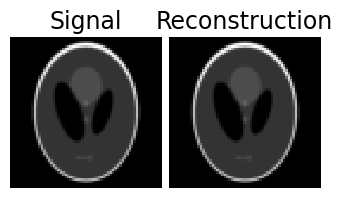

Cosine similarity: 1.0000


In [24]:
x_recon.requires_grad = False
x_recon = correct_global_phase(x_recon, x)
img_recon = torch.angle(x_recon) / (2*torch.pi) + 0.5
img = torch.angle(x) / (2*torch.pi) + 0.5
plot([img, img_recon],titles=["Signal","Reconstruction"],rescale_mode='clip')
print(f"Cosine similarity: {cosine_similarity(x_recon, x):.4f}")

In [59]:
n_channels = 1

denoiser = DRUNet(
    in_channels=n_channels,
    out_channels=n_channels,
    pretrained="download",  # automatically downloads the pretrained weights, set to a path to use custom weights.
    train=False,
    device=device,
) # TODO: use dncnn lipschitz constant
denoiser_complex = to_complex_denoiser(denoiser,mode="abs_angle")

# Try QR decomposition

In [ ]:
A = torch.randn((5,3),dtype=torch.complex64,device=device)
print(A)

tensor([[-0.8743+0.3645j, -0.7821-0.3355j,  0.4701-0.8829j],
        [ 0.4294-1.0614j, -0.3441+0.9698j,  0.0404+1.7377j],
        [-0.2848+0.1911j, -0.6175-0.1912j,  0.0704+0.0362j],
        [-1.1079-0.6402j,  0.1408+0.3108j, -1.6640-0.0430j],
        [ 0.2608+0.4154j,  0.3932+1.1281j,  0.0477+0.4164j]], device='cuda:0')


In [ ]:
Q, R = torch.linalg.qr(A)
print(Q.shape)
print(R.shape)
print(Q@R)

torch.Size([5, 3])
torch.Size([3, 3])
tensor([[-0.8743+0.3645j, -0.7821-0.3355j,  0.4701-0.8829j],
        [ 0.4294-1.0614j, -0.3441+0.9698j,  0.0404+1.7377j],
        [-0.2848+0.1911j, -0.6175-0.1912j,  0.0704+0.0362j],
        [-1.1079-0.6402j,  0.1408+0.3108j, -1.6640-0.0430j],
        [ 0.2608+0.4154j,  0.3932+1.1281j,  0.0477+0.4164j]], device='cuda:0')


In [ ]:
Q@R-A

tensor([[-1.7881e-07+0.0000e+00j,  0.0000e+00+2.9802e-08j,
          1.1921e-07-3.5763e-07j],
        [ 2.9802e-08+0.0000e+00j, -5.9605e-08+5.9605e-08j,
          1.0803e-07-1.1921e-07j],
        [ 0.0000e+00-1.4901e-08j,  0.0000e+00+1.4901e-08j,
          2.9802e-08-5.5879e-08j],
        [-1.1921e-07-5.9605e-08j,  1.4901e-08-2.9802e-08j,
          0.0000e+00-8.5682e-08j],
        [ 0.0000e+00+0.0000e+00j,  5.9605e-08+1.1921e-07j,
         -1.1921e-07-2.9802e-08j]], device='cuda:0')

In [ ]:
print(torch.diag(R))
print(torch.sgn(torch.diag(R)))
print(torch.diag(torch.sgn(torch.diag(R))))

tensor([ 2.0503+0.j,  1.9024+0.j, -2.4322+0.j], device='cuda:0')
tensor([ 1.+0.j,  1.+0.j, -1.+0.j], device='cuda:0')
tensor([[ 1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j]], device='cuda:0')


In [ ]:
B = torch.arange(1,10).reshape(3,3).to(device).to(torch.complex64)
print(B)
print(B*torch.sgn(torch.diag(R))[None,:])

tensor([[1.+0.j, 2.+0.j, 3.+0.j],
        [4.+0.j, 5.+0.j, 6.+0.j],
        [7.+0.j, 8.+0.j, 9.+0.j]], device='cuda:0')
tensor([[ 1.+0.j,  2.+0.j, -3.+0.j],
        [ 4.+0.j,  5.+0.j, -6.+0.j],
        [ 7.+0.j,  8.+0.j, -9.+0.j]], device='cuda:0')


# Try Haar matrix

In [ ]:
physics = dinv.physics.RandomPhaseRetrieval(
    m=3*torch.prod(torch.tensor(x.shape)),
    img_shape=(1, img_size, img_size),
    dtype=torch.complex64,
    device=device,
    use_haar=True,
)

y = physics(x_phase)

Using Haar matrix


In [ ]:
assert torch.allclose((physics.B.A_adjoint(physics.B(x_phase))),x_phase)

In [ ]:
data_fidelity = L2()
#prior = dinv.optim.prior.PnP(denoiser=denoiser_complex)
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-9
step_size = 1e-2

In [ ]:
def spectral_methods_wrapper(y, physics, n_iter=5000, **kwargs):
    x = spectral_methods(y, physics, n_iter=n_iter, **kwargs)
    z = spectral_methods(y, physics, n_iter=n_iter, **kwargs)
    return {"est": (x, z)}

In [ ]:
params_algo = {"stepsize": step_size, "g_param": 0.00}
print("stepsize:", params_algo["stepsize"])
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

x_phase_gd_spec = model(y, physics, x_gt=x_phase)

stepsize: 0.01


Image 0, channel 0 does not have a global phase shift.


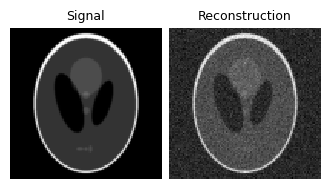

Cosine similarity: 0.9745


In [ ]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# now no global phase shift should exist
#assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / (2*torch.pi) + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')
print(f"Cosine similarity: {cosine_similarity(x_phase_gd_spec, x_phase):.4f}")

# Any size of images

torch.Size([1, 1, 5, 3])


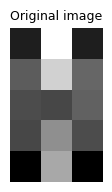

In [90]:
# Load image
img_size = 4
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=(5,3), grayscale=True, resize_mode="resize", device=device
)
print(x.shape)
plot(x, titles="Original image")

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [94]:
input_shape = torch.tensor((1, 5, 3))
output_shape = torch.tensor((1, 6, 3))

change_top = math.ceil(abs(input_shape[1] - output_shape[1])/2)
change_bottom = math.floor(abs(input_shape[1] - output_shape[1])/2)
change_left = math.ceil(abs(input_shape[2] - output_shape[2])/2)
change_right = math.floor(abs(input_shape[2] - output_shape[2])/2)

print(change_left,change_right,change_top,change_bottom)

assert change_left + change_right == abs(input_shape[2] - output_shape[2])
assert change_top + change_bottom == abs(input_shape[1] - output_shape[1])

0 0 1 0


In [95]:
padding = torch.nn.ZeroPad2d((change_left,change_right,change_top,change_bottom))

def trimming(tensor: torch.Tensor):
    if change_bottom == 0:
        tensor = tensor[...,change_top:,:]
    else:
        tensor = tensor[...,change_top:-change_bottom,:]
    if change_right == 0:
        tensor = tensor[...,change_left:]
    else:
        tensor = tensor[...,change_left:-change_right]
    return tensor

In [97]:
x_phase_new = padding(x_phase)
x_phase_new = torch.fft.fft2(x_phase_new, norm='ortho')
x_phase_new = torch.fft.ifft2(x_phase_new, norm='ortho')
x_phase_new = trimming(x_phase_new)

#assert torch.allclose(x_phase_new, x_phase)

print(x_phase_new)
print(x_phase)

tensor([[[[0.2677-0.9635j, 0.7264-0.6872j, 0.2677-0.9635j],
          [0.4067-0.9135j, 0.6459-0.7634j, 0.4291-0.9032j],
          [0.3727-0.9280j, 0.3612-0.9325j, 0.4180-0.9085j],
          [0.3612-0.9325j, 0.5159-0.8566j, 0.3727-0.9280j],
          [0.1958-0.9806j, 0.5677-0.8233j, 0.1958-0.9806j]]]], device='cuda:0')
tensor([[[[0.2677-0.9635j, 0.7264-0.6872j, 0.2677-0.9635j],
          [0.4067-0.9135j, 0.6459-0.7634j, 0.4291-0.9032j],
          [0.3727-0.9280j, 0.3612-0.9325j, 0.4180-0.9085j],
          [0.3612-0.9325j, 0.5159-0.8566j, 0.3727-0.9280j],
          [0.1958-0.9806j, 0.5677-0.8233j, 0.1958-0.9806j]]]], device='cuda:0')


In [89]:
x_random = torch.randn(1, 1, 4, 4).to(device)
print(x_random)
x_random = padding(x_random)
x_random = trimming(x_random)
print(x_random)

tensor([[[[-0.5748, -1.2221,  1.4677,  0.3021],
          [-0.2890, -1.3209, -1.8855,  2.5176],
          [-3.0000, -0.3725, -0.6453, -1.5584],
          [-0.8070, -1.6998, -1.0418,  0.0125]]]], device='cuda:0')
tensor([[[[-0.5748, -1.2221,  1.4677,  0.3021],
          [-0.2890, -1.3209, -1.8855,  2.5176],
          [-3.0000, -0.3725, -0.6453, -1.5584],
          [-0.8070, -1.6998, -1.0418,  0.0125]]]], device='cuda:0')


# Matrix-free eigenvalue computation

In [5]:
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.sparse.linalg import eigs, LinearOperator

def A(x):
    return fft(x,norm='ortho')

# Define a custom linear operator using scipy's LinearOperator
n = 20  # Size of the vector

# Define the shape and the matvec function
linear_operator = LinearOperator((n, n), matvec=A)

# Compute the eigenvalues and eigenvectors using scipy.sparse.linalg.eigs
eigenvalues, eigenvectors = eigs(linear_operator, k=18) # Find 3 eigenvalues

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:\n", eigenvectors)

Eigenvalues: [ 0.00000000e+00-1.00000000e+00j -1.66533454e-16+1.00000000e+00j
  1.00000000e+00+1.11022302e-16j  1.00000000e+00+3.29597460e-16j
 -3.60822483e-16-1.00000000e+00j -4.72319614e-17+1.00000000e+00j
 -1.00000000e+00-2.79724161e-17j -5.89805982e-17-1.00000000e+00j
 -1.14273616e-16+1.00000000e+00j -1.00000000e+00-1.92573517e-17j
  1.00000000e+00+2.22044605e-16j -6.24500451e-17-1.00000000e+00j
 -1.29857220e-17+1.00000000e+00j -1.00000000e+00-1.99523110e-17j
  1.00000000e+00+1.11022302e-16j  0.00000000e+00-1.00000000e+00j
 -1.00000000e+00-2.02221878e-17j  1.00000000e+00-3.46876223e-17j]
Eigenvectors:
 [[-2.11510401e-16+1.63504151e-16j -1.35984181e-16-1.44161176e-16j
   3.57593918e-01+2.33824436e-01j  1.45633607e-01-7.49680074e-02j
  -3.90556409e-18+5.15164908e-17j  6.50948106e-17-8.67480037e-17j
   8.41376108e-02+7.14546561e-02j -2.60686448e-17+1.35614338e-16j
   3.14482702e-17-4.14333014e-17j -3.65685221e-01+7.35085812e-02j
   1.95365488e-02+1.89650495e-03j  6.73534268e-17+1.0651

In [5]:
import numpy as np
import scipy.linalg as la
import torch

from deepinv.physics.phase_retrieval import generate_diagonal

# numpy print options 4 decimal places
np.set_printoptions(precision=1)
# print options line length 200
np.set_printoptions(linewidth=200)

# Function to construct the DFT matrix
def dft_matrix(N):
    n = np.arange(N)
    return np.exp(-2j * np.pi * np.outer(n, n) / N) / np.sqrt(N)

# Size of the FFT
N = 4096

# Construct the DFT matrix
F = dft_matrix(N)

D = generate_diagonal(N, mode='uniform_phase', dtype=torch.complex128)
#print(D)

D = np.diag(D.numpy())

print(F.dtype)

#print("DFT matrix:\n", F)
print('FF', np.max(np.abs(F @ F)))
print('one layer', np.max(np.abs(F @ D)))
print('two layer', np.max(np.abs(F @ D @ F @ D)))
print('three layer', np.max(np.abs(F @ D @ F @ D @ F @ D)))
print('four layer', np.max(np.abs(F @ D @ F @ D @ F @ D @ F @ D)))
print('five layer', np.max(np.abs(F @ D @ F @ D @ F @ D @ F @ D @ F @ D)))
print('six layer', np.max(np.abs(F @ D @ F @ D @ F @ D @ F @ D @ F @ D @ F @ D)))
print('seven layer', np.max(np.abs(F @ D @ F @ D @ F @ D @ F @ D @ F @ D @ F @ D @ F @ D)))

# Compute the eigenvalues of the DFT matrix
#eigenvalues, eigenvectors = la.eig(F)

#print("Eigenvalues of DFT matrix:\n", eigenvalues)

complex128
FF 1.0
one layer 0.015625000731777874
two layer 0.04462331946172852
three layer 0.06769256559714946
four layer 0.06287442181164911
five layer 0.06234664829313186
six layer 0.07076371140602773
seven layer 0.06366389187630415


# Check the variance of every mode of diagonal

In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

import torch

from deepinv.physics.phase_retrieval import generate_diagonal

In [2]:
# uniform_phase
diagonal = generate_diagonal(tensor_shape=(1,1,64,64),mode="uniform_phase",dtype=torch.complex64,device=torch.device("cpu"))
print(diagonal.mean())
print(diagonal.var())

tensor(0.0021-0.0051j)
tensor(1.0002)


In [3]:
# gaussian
diagonal = generate_diagonal(tensor_shape=(1,1,64,64),mode="gaussian",dtype=torch.complex64,device=torch.device("cpu"))
print(diagonal.mean())
print(diagonal.var())

tensor(-0.0006+0.0119j)
tensor(1.0133)


In [4]:
# laplace
diagonal = generate_diagonal(tensor_shape=(1,1,64,64),mode="laplace",dtype=torch.complex64,device=torch.device("cpu"))
print(diagonal.mean())
print(diagonal.var())

tensor(0.0108-0.0034j)
tensor(1.0199)


In [100]:
# student_t
diagonal = generate_diagonal(tensor_shape=(1,1,64,64),mode="student_t",dtype=torch.complex64,device=torch.device("cpu"),df=100)
print(diagonal.mean())
print(diagonal.var())

tensor(0.0148+0.0015j)
tensor(1.0054)
